In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse.csgraph import connected_components
from scipy.sparse.linalg import svds
import networkx as nx
from copy import deepcopy
from scipy import linalg
import scipy.stats as stats
import scipy
import matplotlib.pyplot as plt

The notebook contains the functions used to deal with multipartite graphs - taken from the work we did with microsoft. 

Generally - the functions will take in and out 2 things: 
- the matrix or the embedding
- attributes: two lists, each a dictionary containing information about the rows/columns respectively. 

would be good if: 
* no time results in no time in partitions 
* can specify a weight column 
* how does it so far relate to LMM data? - check with time series data

In [9]:
pip install git+ssh://git@github.com/anniegray52/relastat.git

  Cloning ssh://****@github.com/anniegray52/relastat.git to /tmp/pip-req-build-qtnj2hb1
  Running command git clone -q 'ssh://****@github.com/anniegray52/relastat.git' /tmp/pip-req-build-qtnj2hb1
    ERROR: Command errored out with exit status 1:
     command: /usr/bin/python3 -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-req-build-qtnj2hb1/setup.py'"'"'; __file__='"'"'/tmp/pip-req-build-qtnj2hb1/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-req-build-qtnj2hb1/pip-egg-info
         cwd: /tmp/pip-req-build-qtnj2hb1/
    Complete output (8 lines):
    running egg_info
    creating /tmp/pip-req-build-qtnj2hb1/pip-egg-info/relastat.egg-info
    writing /tmp/pip-req-build-qtnj2hb1/pip-egg-info/relastat.egg-info/PKG-INFO
    writing dependency_links to /tmp/pip-req-build-qtnj2hb1/pip-egg-info/relastat.egg-info/depend

In [2]:
# replace with own path to data folder:
# path = 'path_to_data_folder'
# path = '/home/ag16115/Documents/phd/codebase_data/brazil'

In [3]:
from preprocessing import *
from embedding import *
from misc import *

# dynamic - lyon school 

In [4]:
# load data 
# need the activity_data.csv file
path = '/home/ag16115/Documents/phd/codebase_data/'
data = pd.read_csv(path + 'ia-primary-school-proximity-attr.edges', sep = ',', on_bad_lines='skip', header = None)
# data = pd.read_csv(path + '/activity_data.csv', sep = '\t', on_bad_lines='skip')

In [5]:
## rename columns   
data.columns = ['V1', 'V2', 'T', 'L1', 'L2']
## sort out time column
data['H'] = [int(int(t)/(60*60)) for t in list(data['T'])]
data['D'] = [int(int(t)/(60*60*24)) for t in list(data['T'])]
data['T1'] = [10*int(i/24) + i%24 - 8 for i in list(data['H'])]

In [6]:
def scree_plot(A, s = 1, vline=None):
    UA, SA, VAt = scipy.sparse.linalg.svds(A,k=50)
    SA = SA[::-1]

In [7]:
def scree_plot(A, k = 50, s = 10, vline=None):
    UA, SA, VAt = scipy.sparse.linalg.svds(A,k=k)
    fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
    plt.scatter(range(len(SA)), np.sort(SA)[::-1], s =s)
    if vline:
        plt.axvline(x=vline, color='green', linewidth=0.5)
        
# def subspace_scree_plots(embeddings, s = 1, vlines=None):
#     fig, axs = plt.subplots(len(embeddings), figsize=(12,4*len(embeddings)))
#     fig.patch.set_facecolor('white')
#     for i, p in enumerate(embeddings.keys()):
#         axs[i].title.set_text(p)
#         axs[i].scatter(range(len(embeddings[p].metadata['partition singular values'])), np.sort(embeddings[p].metadata['partition singular values'])[::-1], s =s)
#         if vlines:
#             axs[i].axvline(x=vlines[i], color='green', linewidth=0.5)

In [8]:
A, attributes = matrix_from_tables(data, ['V1','V2'], dynamic_col='T', join_token='::')

['V1', 'V2']


In [9]:
A 

<242x750200 sparse matrix of type '<class 'numpy.float64'>'
	with 251546 stored elements in Compressed Sparse Row format>

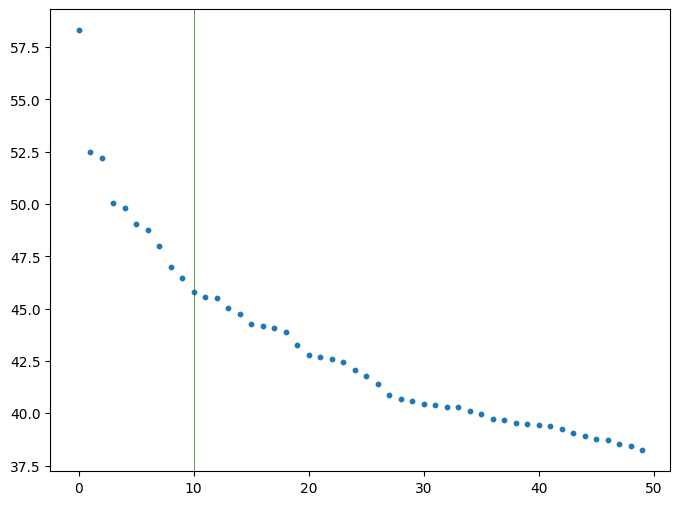

In [10]:
d = 10
scree_plot(A, k = 50,s = d, vline=10)

In [14]:
A.shape

(242, 750200)

In [15]:
d = 10
embedding = embed(A, d = d, right_embedding=True)
LHS = embedding[0]  
RHS = embedding[1]  

LHS = degree_correction(LHS)      
RHS = degree_correction(RHS)  


/home/ag16115/Documents/phd/codebase/embedding.py:192: UserWarning: Warning: More than one connected component in the graph.
  warnings.warn(


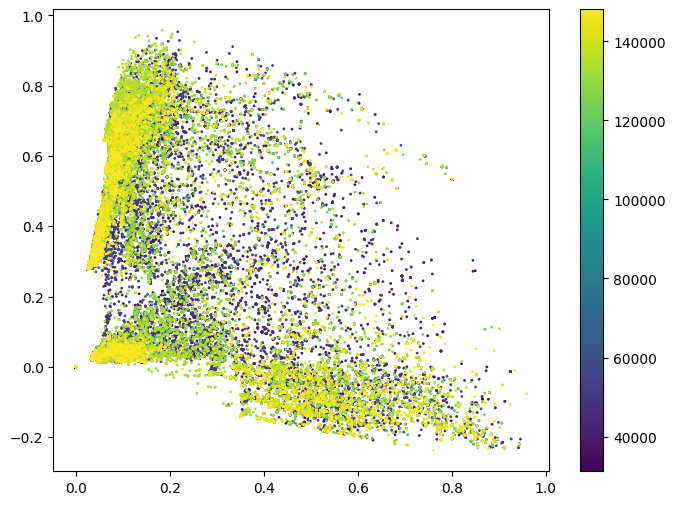

In [16]:
## plot the right hand side embedding and colour by time    
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')   
plt.scatter(RHS[:,0], RHS[:,1], c = [att['time'] for att in attributes[1]], s = 1, cmap = 'viridis')    
plt.colorbar()
plt.show()

# multipartite - brazil

The data contains information about the procurement process in Brazil. Each row contains information about a tender with information:
- Tender: tender id
- Period: time 
- Buyer: who is funding
- Item: what the tender is abour 
- Company: who has bid for the tender
- bidder_win: whether the bid was won or not

In [ ]:
data = pd.read_csv(path + 'brazil/activity_data.csv', sep = '\t', on_bad_lines='skip')
A, attributes = matrix_from_tables(data, [['Company', 'Tender'], ['Company', 'Buyer'],['Company', 'Item']],dynamic_col = 'Period', join_token='::')

/tmp/ipykernel_27914/558244675.py:1: DtypeWarning: Columns (13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path + 'brazil/activity_data.csv', sep = '\t', on_bad_lines='skip')


['Company', 'Tender']
['Company', 'Buyer']
['Company', 'Item']


In [ ]:
# find subgraph wanted

subgraph_attributes = [
    [{'partition': 'Company'},{'partition': 'Tender'}],
    {'partition': 'Buyer'}
]

# subgraph_attributes = [
#     {'partition': 'Company'},
#     {'partition': 'Buyer'}
# ]
subgraph_A, subgraph_attributes  = find_subgraph(A, attributes,subgraph_attributes)

In [ ]:
# A_dilation = symmetric_dilation(subgraph_A)
# is_symmetric(A_dilation)

In [ ]:
# take the largest connected component
cc_A, cc_attributes = find_connected_components(A, attributes,n_components = 1)

Number of connected components: 217748


In [ ]:
cc_A.shape

(21792, 392256)

In [ ]:
d = 10
embedding = embed(A, d=d, matrix='adjacency', regulariser=0)

/home/ag16115/Documents/phd/codebase/embedding.py:202: UserWarning: Warning: More than one connected component in the graph.
  warnings.warn(


# toy data

In [ ]:
df = pd.DataFrame(
    {'A': ['a1', 'a1', 'a2', 'a2', 'a1', 'a1', 'a2', 'a2'],
        'B': ['b1', 'b2', 'b1', 'b2', 'b1', 'b2', 'b1', 'b2'],
        'ID': [1, 1, 1, 1, 2, 2, 2, 2]})
relationships = ['A', 'B']
time_col = 'ID'
A1, attributes1 = matrix_from_tables(
    df, relationships, dynamic_col=time_col, join_token='::')

c0, att0 = find_cc_containing_most(A1, attributes1, 'B', dynamic=False)
c1, att1 = find_cc_containing_most(A1, attributes1, 'A', dynamic=True)

['A', 'B']
Number of connected components: 2
Number of connected components: 2


# weighted - harry potter 

## needs to be incorporated

In [ ]:
path = '/home/ag16115/Documents/phd/codebase_data'
data = pd.read_csv(path + '/harry_potter.csv', sep=',')
attributes = pd.read_csv(path + '/HP-characters.csv', sep=',')

In [ ]:
## replace - in type column to -1 and + to 1    
data['type'] = [1 if t == '+' else -1 for t in list(data['type'])]

In [ ]:
A, attributes = matrix_from_tables(data, ['source','target'], weight_col=None)

['source', 'target']


# time series

In [ ]:
data = pd.read_csv(path + '/sp500_data.csv', sep=',')

In [ ]:
def matrix_from_time_series(data, time_col, drop_nas = True):
    data = data.sort_values(by=time_col)
    data = data.dropna(axis=1, how='any')

    times = list(data[time_col])
    data.drop([time_col], axis=1, inplace=True)
    ids = list(data.columns)

    Y = np.array(data).T
    attributes = [
        [{'name': i} for i in ids], [{'time': i} for i in times]
    ]
    return Y, attributes

In [ ]:
Y, attributes = matrix_from_time_series(data, 'date')

In [ ]:
Y.shape

(468, 1259)

In [ ]:
(n,p) = Y.shape

# text analysis

In [17]:

from textblob import Word
from nltk.corpus import stopwords
import nltk
import re
from pprint import pprint
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ag16115/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
# def pc_scores(X, r):
#     U, s, Vh = svds(X, k=r)
#     idx = s.argsort()[::-1]
#     Vh = Vh[idx, :]
#     Y = X @ Vh.T
#     return Y

In [19]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups()  # remove=('headers', 'footers', 'quotes')
# # pprint(list(newsgroups.target_names))

# create dataframe from newsgroup data
df = pd.DataFrame()
df["data"] = newsgroups["data"]

In [20]:
def del_email_address(text):
    e = '\S*@\S*\s?'
    pattern = re.compile(e)
    return pattern.sub('', text)

def clean_text_(text):
    return " ".join([Word(word).lemmatize() for word in re.sub("[^A-Za-z0-9]+", " ", text).lower().split()]) 

def remove_stopwords_(text, stopwords): 
    return " ".join([word for word in text.split() if word not in stopwords])

def matrix_from_text(data, column_name, remove_stopwords=True, clean_text = True, 
                     remove_email_addresses = False, update_stopwords = None,
                     **kwargs):
    """
    Create a matrix from a column of text data.
    """

    ## gets rid of email addresses  in data
    if remove_email_addresses:
        data[column_name] = data.data.apply(lambda row: del_email_address(row))

    if clean_text:
        # gets rid of stopwords, symbols, makes lower case and base words
        data[column_name] = data.data.apply(lambda row: clean_text_(row))

    if remove_stopwords:
        stopwords = set(nltk.corpus.stopwords.words("english"))
        if update_stopwords is not None:
            stopwords.update(update_stopwords)
        data[column_name] = data.data.apply(
            lambda row: remove_stopwords_(row, stopwords))
   
    # create tfidf matrix
    vectorizer = TfidfVectorizer(**kwargs)
    Y = vectorizer.fit_transform(data.data)
    attr0 = [{'name': i} for i in vectorizer.get_feature_names_out()]
    attr1 = [{'name': 'document_' + str(i)} for i in list(data.index)]
    attributes = [attr0, attr1]
    return Y, attributes

In [1]:
pip install sphinx

  Using cached sphinx-7.1.2-py3-none-any.whl (3.2 MB)
  Using cached sphinxcontrib_htmlhelp-2.0.1-py3-none-any.whl (99 kB)
  Using cached docutils-0.20.1-py3-none-any.whl (572 kB)
  Using cached imagesize-1.4.1-py2.py3-none-any.whl (8.8 kB)
  Using cached sphinxcontrib_serializinghtml-1.1.5-py2.py3-none-any.whl (94 kB)
  Using cached snowballstemmer-2.2.0-py2.py3-none-any.whl (93 kB)
     |████████████████████████████████| 90 kB 3.9 MB/s eta 0:00:011
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
     |████████████████████████████████| 53 kB 1.8 MB/s  eta 0:00:01
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Using cached sphinxcontrib_applehelp-1.0.4-py3-none-any.whl (120 kB)
     |████████████████████████████████| 84 kB 4.0 MB/s  eta 0:00:01
  Using cached alabaster-0.7.13-py3-none-any.whl (13 kB)
     |████████████████████████████████| 10.1 MB 35.8 MB/s eta 0:00:01
  Using cached MarkupSafe-2.1.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
    

In [21]:
Y,attributes = matrix_from_text(data, 'data', remove_stopwords=True, clean_text = True, 
                     remove_email_addresses = True, update_stopwords = ['subject'],
                     min_df = 5, max_df = len(df)-1000)

AttributeError: 'DataFrame' object has no attribute 'data'

In [ ]:
for i in range(len(attributes[1])):
    attributes[1][i].update(
        {'label': newsgroups["target_names"][newsgroups["target"][i]]})

In [ ]:
df1 = pd.DataFrame(
    ['This is a test sentence', 'This is another test sentence', 'This contains an email address: email_address@email.com'], columns=['data'])

Y1, attributes1 = matrix_from_text(df1, 'data', remove_email_addresses=True)